# **Contents**


* (1) Preprocessing and feature engineering
* (2) Generating and analyzing models
* (3) Feature importance and model pruning
* (4) Practical meaning of the model




# Predicting thyroid cancer recurrence: Introduction and summary


This project uses a [dataset](https://archive.ics.uci.edu/dataset/915/differentiated+thyroid+cancer+recurrence) consisting of 383 observations and 16 features (383x16 data matrix) based on the medical history of patients and one target feature representing the recurrence of previous thyroid cancer. PR_AUC was used as a model selection metric. A linear SVM model was selected and bootstrapped confidence intervals was used for feature selection. The final, pruned model yielded a PR_AUC of 97%, a recall of 90%, and a precision of 94% all for a singular holdout set.






# **(1)** Preprocessing and feature engineering

This section prepares the data for model generation. Missing values and outliers will be addressed. Encoding and ranking features, then some feature engineering.



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA





df=pd.read_csv('/content/Thyroid_Diff.csv') # Extract raw data

print(df.head()) # Display first 5 observations


   Age Gender Smoking Hx Smoking Hx Radiothreapy Thyroid Function  \
0   27      F      No         No              No        Euthyroid   
1   34      F      No        Yes              No        Euthyroid   
2   30      F      No         No              No        Euthyroid   
3   62      F      No         No              No        Euthyroid   
4   62      F      No         No              No        Euthyroid   

          Physical Examination Adenopathy       Pathology     Focality Risk  \
0   Single nodular goiter-left         No  Micropapillary    Uni-Focal  Low   
1          Multinodular goiter         No  Micropapillary    Uni-Focal  Low   
2  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
3  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
4          Multinodular goiter         No  Micropapillary  Multi-Focal  Low   

     T   N   M Stage       Response Recurred  
0  T1a  N0  M0     I  Indeterminate       No  
1  T1a  N0  M0  

# **(1.1)** Cleansing: Addressing missing values and outliers

The missing values are entirely in the "Response" column referring to the patient's response to previous treatment for cancer and the missing values are numerous. Feature importance bar charts in later sections show that response to previous treatment is consistently ranked as one of the most important features across various classification models. We will impute these missing values using a K-nearest neighbours model after feature engineering.

As for outliers, we will inspect the age column as it will be the only column that is not a rank-based or categorical. First, let's inspect how age is distributed so we can decide an appropriate method of outlier detection and removal.




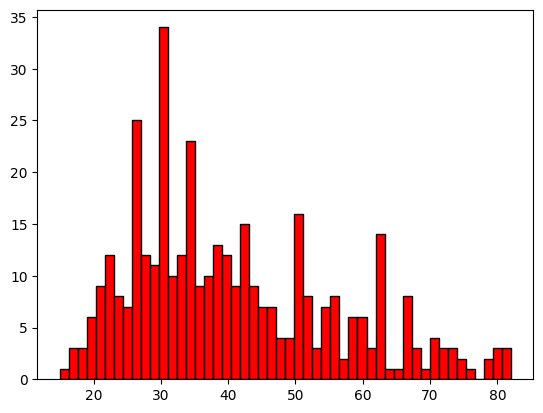

In [ ]:
plt.hist(df['Age'],bins=50, color='red',edgecolor='black')
plt.show()

This data is significantly skewed and doesn't appear normal. So we will use the IQR method for detection.

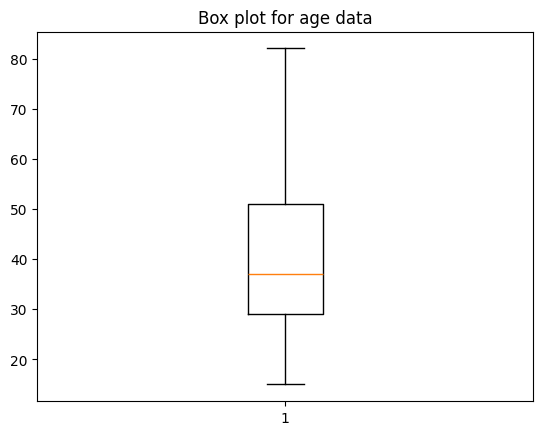

In [ ]:
plt.boxplot(df['Age'])
plt.title("Box plot for age data")
plt.show()

Our boxplot demonstrates that age does not have outliers.

# **(1.2)** Encoding, ranking, and normalizing (some) features.

*   Normalizing columns with a wide range of values like age. We will not normalize binary or rank-based features as we will only be using a few ranks for each rank-based feature. We want to maintain the distance between the ranks that we have assigned and not have it possibly distorted by normalization.
*   Extracting binary features (e.g, 0 or 1)
*   Extracting rank-based features (e.g, 1, 2, 3 ..)

The logic behind the rankings will be detailed extensively.









In [ ]:
df['Age']=(df['Age']-df['Age'].mean())/df['Age'].std()




*   Assign binary features 0 or 1
*   Hx means "History of"
*   "Recurred" is whether thyroid cancer has recurred or not
*   The "M" feature refers to metastasis
*   "Response" refers to response to cancer treatments. "Structural incomplete" means there are bodily displays of the cancer's persistence. "Biochemical incomplete" means there are biochemical signatures of the cancer's persistence. The indicators of the persistence are irrelevant so they both get a value of 1 for persistence. "Excellent" gets 0.
*  "N" represents how much the cancer has spread specifically in terms of what lymph nodes it has spread to. "N0" means there is no spread to nearby lymph nodes. "N1a" means there is spread to nearby lymph nodes but still contained in the central region. "N1b" means it has spread to the lateral neck. N0, N1a, N1b will be coded as 0,1,2, respectively.








In [ ]:
df['Gender']=df['Gender'].replace(['F','M'],[0,1])

df['Smoking']=df['Smoking'].replace(['No','Yes'],[0,1])

df['Hx Smoking']=df['Hx Smoking'].replace(['No','Yes'],[0,1])

df['Hx Radiothreapy']=df['Hx Radiothreapy'].replace(['No','Yes'],[0,1])

df['Recurred']=df['Recurred'].replace(['No', 'Yes'], [0,1])

df['M']=df['M'].replace(['M0', 'M1'], [0,1])

df['Response']=df['Response'].replace(['Structural Incomplete','Biochemical Incomplete', 'Excellent'], [1,1,0])

df['N']=df['N'].replace(['N0','N1a','N1b'],[0,1,2])

print(df['Response'].unique())

['Indeterminate' 0 1]


<ipython-input-75-6e68e0061b6c>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender']=df['Gender'].replace(['F','M'],[0,1])
<ipython-input-75-6e68e0061b6c>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Smoking']=df['Smoking'].replace(['No','Yes'],[0,1])
<ipython-input-75-6e68e0061b6c>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_op



*   Thyroid function (or dysfunction) should be thought of purely in terms of
magnitude, not direction. That is, the hypo-hyper distinction should not be treated as information. What is treated as information is the magnitude. That is, the clinical-subclinical distinction. Euthyroid means it is a healthy thyroid and gets a value of 0. Subclinical and clinical dysunction gets values of 1 and 2 respectively.

* "Risk" is the risk of recurrence.
*   "T" refers to the magnitude of the primary tumour which is ranked numeric-alphabetically.
*   "Focality" is the number of distinct growths in the primary cancer site.
*   "Adenopathy" is swelling of the lymph node. Here, we apply the same logic with ranking thyroid function/dysfunction. But with "bilateral", both directions suggest another order of magnitude. "Extensive" is the maximum rank.
* "Stage" is the stage of the previous cancer
*   "Physical Examination" is the kind of goiter found in a physical examination.
*  "Pathology" is the type of cancer found. These could be ranked in terms of size and aggression, so I created two new features. "Pathologic size" is pathology ranked by size. "Pathologic aggression" is pathology ranked by aggression.












In [ ]:
df['Thyroid Function']=df['Thyroid Function'].replace(['Clinical Hypothyroidism', 'Subclinical Hypothyroidism', 'Euthyroid', 'Subclinical Hyperthyroidism','Clinical Hyperthyroidism'], [2,1,0,1,2])
# Rename column
df['Thyroid Dysfunction']=df['Thyroid Function']
df=df.drop(columns='Thyroid Function', axis=1)

df['Risk']=df['Risk'].replace(['Low', 'Intermediate', 'High'], [1,2,3])

df['T']=df['T'].replace(['T1a', 'T1b', 'T2a', 'T2', 'T2b', 'T3a', 'T3b', 'T4a', 'T4b'], range(1,10))

df['Focality']=df['Focality'].replace(['Uni-Focal','Multi-Focal'], [1,2])

df['Adenopathy']=df['Adenopathy'].replace(['No','Left','Right','Posterior','Bilateral','Extensive'],[1,2,2,2,3,4])

df['Stage']=df['Stage'].replace(['I', 'II', 'III', 'IVA', 'IVB'], range(1,6))

df['Physical Examination']=df['Physical Examination'].replace(['Normal','Single nodular goiter-right', 'Single nodular goiter-left', 'Diffuse goiter', 'Multinodular goiter'],[0,1,1,1,2])

df['Pathologic size']=df['Pathology']

df['Pathologic aggression']=df['Pathology']

df['Pathologic size']=df['Pathology'].replace(['Micropapillary', 'Papillary', 'Follicular', 'Hurthel cell'], [1,2,3,4])

df['Pathologic aggression']=df['Pathology'].replace(['Micropapillary', 'Papillary', 'Follicular', 'Hurthel cell'], [2,1,3,4])


df=df.drop(columns=['Pathology'])
df.reset_index(inplace=True)


<ipython-input-76-459f6690c0c9>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Thyroid Function']=df['Thyroid Function'].replace(['Clinical Hypothyroidism', 'Subclinical Hypothyroidism', 'Euthyroid', 'Subclinical Hyperthyroidism','Clinical Hyperthyroidism'], [2,1,0,1,2])
<ipython-input-76-459f6690c0c9>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Risk']=df['Risk'].replace(['Low', 'Intermediate', 'High'], [1,2,3])
<ipython-input-76-459f6690c0c9>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and wil

In [ ]:
print(df.head())

   index       Age  Gender  Smoking  Hx Smoking  Hx Radiothreapy  \
0      0 -0.916241       0        0           0                0   
1      1 -0.453721       0        0           1                0   
2      2 -0.718018       0        0           0                0   
3      3  1.396357       0        0           0                0   
4      4  1.396357       0        0           0                0   

   Physical Examination  Adenopathy  Focality  Risk  T  N  M  Stage  \
0                     1           1         1     1  1  0  0      1   
1                     2           1         1     1  1  0  0      1   
2                     1           1         1     1  1  0  0      1   
3                     1           1         1     1  1  0  0      1   
4                     2           1         2     1  1  0  0      1   

        Response  Recurred  Thyroid Dysfunction  Pathologic size  \
0  Indeterminate         0                    0                1   
1              0         0  

# **(1.3)** KNN Imputation

Missing values in the "Response" representing response to previous cancer is represented by "Indeterminate". A new dataframe (named rdf) removing these missing values will be used to train the KNN imputer.

We use KNN imputation because the final model shows that response to previous treatment is a serious predictor of recurrence. We can't just remove these missing values. The information is just too valuable.

In [ ]:
KNN_imputer=KNeighborsClassifier()
rdf=df[df['Response']!='Indeterminate'] #rdf means dataframe with removed values. This will be used to train the KNN_imputer

yf=rdf['Response'].astype(int)
Xf=rdf.drop(columns=['Response', 'Recurred']) # Both target and column used for imputation gets removed

KNN_imputer.fit(Xf,yf)
df['Response']=df['Response'].replace(['Indeterminate'], [KNN_imputer.predict(df.drop(columns=['Response', 'Recurred'],axis=1))])

<ipython-input-78-c24337d7da0e>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Response']=df['Response'].replace(['Indeterminate'], [KNN_imputer.predict(df.drop(columns=['Response', 'Recurred'],axis=1))])


# **(1.4)** Feature engineering: Introducing interaction and polynomial terms.

Interactions between response, risk, and age will be explored in this model.

In [ ]:
df['Response x Age']=df['Response']*df['Age']
df['Response x Age^2']=df['Response']*df['Age']**2
df['Response x Risk']=df['Response']*df['Risk']
df['Response x Risk^2']=df['Response']*df['Risk']**2
df['Response x Age x Risk']=df['Response']*df['Age']*df['Risk']

# **(2)** Generating, analyzing, and selecting models.

The costs of different kinds of misclassifications and the imbalance of classes will be discussed and used as a basis for a selection of a performance metric, and finally a model.





# **(2.1)** Generating the models and their performance metrics

Define the features and target (recurrence of cancer)

In [ ]:
from sklearn.model_selection import train_test_split

y=df['Recurred']
X=df.drop(columns=['Recurred'])



Generate and fit the models. Then, save the performance metrics in a dataframe. The code used will be stored in a function "get_results" because it will be re-used after pruning the model based on feature importance.

In [ ]:


def get_results(X,y, models_selected):

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42)


  models = {
      'Standard Logistic Regression': LogisticRegression(),
      'Balanced Logistic Regression': LogisticRegression(class_weight='balanced'),
     'Decision Tree': DecisionTreeClassifier(max_depth=3),
     'Random Forest': RandomForestClassifier(n_estimators=300,max_depth=3),
      'Linear SVM': SVC(kernel='linear', probability=True),
      'Polynomial SVM': SVC(kernel='poly', degree=3, probability=True),
      'Radial SVM': SVC(kernel='rbf', probability=True),
      'K-Nearest Neighbors': KNeighborsClassifier(),
      'Naive Bayes': GaussianNB(),
      }


  results=[]

  for name, model in models.items():

      if name in models_selected or models_selected=='all':


        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        class_report = classification_report(y_test, y_pred, output_dict=True)
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

        pr_auc = auc(recall, precision)


        results.append({
            'Model': name,
            'PR_AUC': pr_auc,
            'Precision (Recurrence)': class_report['1']['precision'],
            'Precision (Non-recurrence)': class_report['0']['precision'],
            'Recall (Recurrence)': class_report['1']['recall'],
            'Recall (Non-recurrence)': class_report['0']['recall'],
            'F1-Score (Recurrence)': class_report['1']['f1-score'],
            'F1-Score (Non-recurrence)': class_report['0']['f1-score'],
            #'0.8*Recall + 0.2*Precision': class_report['1']['recall']*0.8+class_report['1']['precision']*0.2
            #'Classification Report': class_report
            })


  results_df = pd.DataFrame(results)
  #plt.show()
  return results_df


Display the precision, recall, F1-score for each class in each model in the holdout set.

In [ ]:
print(get_results(X,y, 'all'))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

                          Model    PR_AUC  Precision (Recurrence)  \
0  Standard Logistic Regression  0.991324                0.935484   
1  Balanced Logistic Regression  0.993166                0.939394   
2                 Decision Tree  0.946592                0.906250   
3                 Random Forest  0.979408                0.937500   
4                    Linear SVM  0.993530                0.967742   
5                Polynomial SVM  0.862002                0.923077   
6                    Radial SVM  0.791011                0.920000   
7           K-Nearest Neighbors  0.971573                0.937500   
8                   Naive Bayes  0.951869                0.911765   

   Precision (Non-recurrence)  Recall (Recurrence)  Recall (Non-recurrence)  \
0                    0.964286              0.90625                 0.975904   
1                    0.987805              0.96875                 0.975904   
2                    0.963855              0.90625                 0.963

# **(2.2)** Analyzing performance metrics

High precision, recall, and F1-score for both classes is consistent across all the classification models.

High precision and recall for both classes conveys that our models rarely generate false negatives or false positives. **It has powerful distinguishing ability**.

# **(2.3)** How exactly should we select a model?

There is considerable imbalance in our data where barely 30% of our target data are recurrence of cancer, and a focus on the positive (recurrence) class is called for by the egregious cost of a false negative. On this basis, we will use the PR_AUC metric to select a model. **The model with the highest area under the precision-recall curve is the linear support vector machine**.

# **(3)** Feature importance and model pruning.

We will use bootstrapping to simulate the distribution of the coefficient estimates for the linear SVM. Any coefficient whose 95% confidence CI doesn't contain zero will stay in the model.

In [ ]:
X=X.drop(columns=['index'])

X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42)

alpha=0.05
estimate_matrix=[]
n_estimates=1000
model=SVC(kernel='linear')

for i in range(n_estimates):

  X_resample,y_resample=resample(X_train,y_train, replace=True)

  model.fit(X_resample,y_resample)

  coefficient_vector=model.coef_[0]

  estimate_matrix.append(coefficient_vector)



coef_distributions=np.transpose(estimate_matrix) # If each row of estimate_matrix is a coefficient vector, then each row of the transpose is the distribution of a specific coefficient estimate
feature_names=X_train.keys()
percent=(1-alpha)*100
low_percentile=(alpha/2)*100
upper_percentile=(1-alpha/2)*100
kept_columns=[]
point_estimates=[]
index=0


for distribution in coef_distributions:
  low_bound=np.percentile(distribution, low_percentile)
  upper_bound=np.percentile(distribution, upper_percentile)
  pt_est=round((low_bound + upper_bound) / 2, 3)

  if low_bound*upper_bound >=0 and pt_est !=0:
    kept_columns.append(feature_names[index])
    point_estimates.append(pt_est)

  index=index+1




In [ ]:
X_new=X[kept_columns]


print('Features kept with their coefficients: \n'+'-----------------------------------------------------------------')

for k in range(len(kept_columns)):
  print(kept_columns[k], ' = '+str(point_estimates[k]))

new_results=get_results(X_new,y, ['Linear SVM'])
print('-----------------------------------------------------------------', '\n')

print(new_results)


Features kept with their coefficients: 
-----------------------------------------------------------------
Gender  = 1.17
Smoking  = -0.678
N  = 0.784
M  = 0.327
Response  = 0.84
Response x Risk  = 0.69
Response x Risk^2  = 0.483
----------------------------------------------------------------- 

        Model    PR_AUC  Precision (Recurrence)  Precision (Non-recurrence)  \
0  Linear SVM  0.971411                0.935484                    0.964286   

   Recall (Recurrence)  Recall (Non-recurrence)  F1-Score (Recurrence)  \
0              0.90625                 0.975904               0.920635   

   F1-Score (Non-recurrence)  
0                    0.97006  


# **(4)** Practical meaning of the model


The attributes that are predictive of recurring thyroid cancer are gender, smoking, the magnitude of previous cancer spread in terms of lymph nodes involved, metastasis, response to previous cancer, and risk.

The effect that previous response has on recurrence is dependent on risk. Specifically, the effect of previous response actually accelerates with risk given we have a significant Response x Risk and Response x Risk^2 effect.